Included stations =  [ 519.  497.  435.  402.  426.  490. 3255.  477.  514.  459.  368.  293.
  281. 2006.  499.  382.  358.  523. 3002.  492.  229.  379. 3263.  151.
  168.  505.  387.  359.  504.  432. 3435.  446.  465.  327.  491. 3427.
  509.  128.  442. 3164.  445.  127.  173.  472.  479.  496.  486.  482.
  297.  453. 3141.  483.  466.  450.  458.  498.  237. 3256.  518.  494.
  517.  507.  545. 3260. 3443.  347. 3165.  380. 2008.  312. 3233.  461.
  251. 3167.  468. 3258.  236.  487.  336.  401.  531. 2003. 2021.  212.
  383.  503.  540.  417.  307.  478.  410. 3137.  524.  438.  529.  530.
  326.  304. 3163.  265.  526. 3158.  476. 3282.  528.  315.  447. 3236.
  536. 3244.  361.  501.  301.  167.  448.  520.  546.  377.  305. 3159.
  412.  335.  268.  495. 3016.  195. 3142.  319.  267.  539.  388. 3429.
 3168.  363. 3093.  508.  484.  317. 3374.   72.  346.  525.  480.  469.
 3140.  174.  532. 3223. 3235. 2012.  394.  328.  325.  500. 3147.  485.
  252.  355.  303.  279.  257.

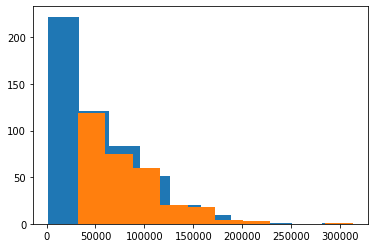

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

# only use 2017 data for constructing adjacency matrices to prevent leakage

persistent_counts = pd.read_csv('./persistent_counts.csv', names=['start_id', 'total_counts'],header=0)
plt.hist(persistent_counts['total_counts'])

top_n_stations = 300
popular_stations = persistent_counts[:top_n_stations]['start_id'].values

plt.hist(persistent_counts[:top_n_stations]['total_counts'])

print("Included stations = ", popular_stations)
print("Minimum number of trips = ", persistent_counts.loc[top_n_stations-1]['total_counts'])

station_id_dict = dict(zip(popular_stations,np.arange(popular_stations.shape[0])))

In [2]:
col_names = ['trip_duration',
                     'start_time',
                     'stop_time',
                     'start_id',
                     'end_id',
                     'start_lat',
                     'end_lat',
                     'start_long',
                     'end_long']

years = [2017, 2018]
months = [i for i in range(1,13)]

START_REF_TIME = pd.to_datetime(f'{years[0]}-{months[0]:02d}-01')
END_REF_TIME = pd.to_datetime(f'{years[0]+1}-{months[0]:02d}-01')

all_df = None

for year in years:
    for month in months:

        path_to_file = f'/Users/varunursekar/Projects/advDeepLearning/bike_share/data/{year}{month:02d}-citibike-tripdata.csv'
        df = pd.read_csv(path_to_file)
        
        col_name_mapper = {}

        for col in df.columns:

            string = col.lower()

            if 'trip' in string and 'duration' in string:
                col_name_mapper['trip_duration'] = col
            elif 'start' in string and 'time' in string:
                col_name_mapper['start_time'] = col
            elif 'stop' in string and 'time' in string:
                col_name_mapper['stop_time'] = col
            elif 'start' in string and 'station' in string and 'id' in string:
                col_name_mapper['start_id'] = col
            elif 'end' in string and 'station' in string and 'id' in string:
                col_name_mapper['end_id'] = col
            elif 'start' in string and 'station' in string and 'latitude' in string:
                col_name_mapper['start_lat'] = col
            elif 'end' in string and 'station' in string and 'latitude' in string:
                col_name_mapper['end_lat'] = col
            elif 'start' in string and 'station' in string and 'longitude' in string:
                col_name_mapper['start_long'] = col
            elif 'end' in string and 'station' in string and 'longitude' in string:
                col_name_mapper['end_long'] = col


        col_name_mapper = dict(zip(list(col_name_mapper.values()),list(col_name_mapper.keys())))
        
        df = df.rename(columns=col_name_mapper)
        df = df[col_names]      
        df = df.dropna() # drop rows where any of the desired cols are missing
        
        df = df[(df['start_id'].isin(popular_stations)) & (df['end_id'].isin(popular_stations))]
        df['start_time'] = pd.to_datetime(df['start_time'])
        df['stop_time'] = pd.to_datetime(df['stop_time'])
        
        if all_df is None:
            all_df = df
        else:
            all_df = pd.concat([all_df,df],ignore_index=True)



In [3]:
# add additional columns to analyze
all_df['trip_count'] = 1
all_df['month'] = all_df['start_time'].apply(lambda x: x.month)
all_df['dow'] = all_df['start_time'].apply(lambda x: x.dayofweek)
all_df['hour'] = all_df['start_time'].apply(lambda x: x.hour)
all_df['is_weekday'] = all_df['dow'].apply(lambda x: 1 if x<5 else 0)

In [4]:
# double check that we have all the data
print(all_df['start_id'].unique().shape == all_df['end_id'].unique().shape)

True


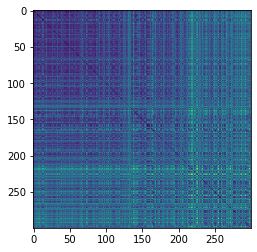

In [5]:
latlong_df = all_df[['start_id','start_lat','start_long']].drop_duplicates()
latlong_df = latlong_df.groupby(by='start_id').mean().reset_index()

latlong_dict = {}

for index, row in latlong_df.iterrows():
    latlong_dict[int(row[0])] = np.array([row[1],row[2]])

num_stations = len(popular_stations)
distances = np.inf * np.ones((num_stations,num_stations))

measure = np.array([69.,79.])**2

for i, station_i in enumerate(popular_stations):
    for j, station_j in enumerate(popular_stations):
                
        distances[i,j] = np.sqrt(measure.dot((latlong_dict[station_i]-latlong_dict[station_j])**2))
        
plt.figure()
plt.imshow(distances)

In [8]:
np.save(f'./latlong_distances_top_{top_n_stations}',distances)

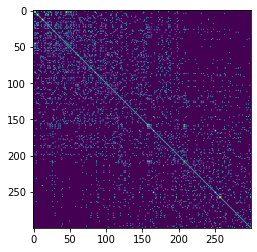

In [6]:
plt.figure()
q = np.quantile(distances,0.05)
adj = np.copy(distances)
adj[adj>q] = np.inf
adj = np.exp(-adj**2)
plt.imshow(adj)

In [4]:
def make_matrix(df,icol,jcol,metric,station_id_dict,fill=0.):
    
    n = len(station_id_dict)
    mat = fill * np.ones((n,n))
    
    for index, row in df.iterrows():
        
        i = station_id_dict[row[icol]]
        j = station_id_dict[row[jcol]]
        
        mat[i,j] = row[metric]        
        
    return mat

In [5]:
tc_df = all_df[['start_id','end_id','trip_count']]. \
                groupby(by=['start_id','end_id',]).sum().reset_index(level=[1,0])

tc_adj = make_matrix(tc_df,'start_id','end_id','trip_count',station_id_dict,fill=1)

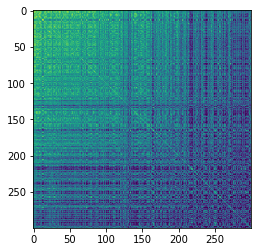

In [6]:
plt.imshow(np.log(tc_adj))

In [9]:
np.save(f'./trip_counts_{years[0]}{months[0]:02d}_{years[-1]}{months[-1]:02d}_top_{top_n_stations}',tc_adj)

In [8]:
tc_wd_df = all_df[['start_id','end_id','is_weekday','trip_count']]. \
                groupby(by=['is_weekday','start_id','end_id',]).sum().reset_index(level=[2,1,0])

weekday_adjs = {}

for is_weekday in [0,1]:

    temp = tc_wd_df[tc_wd_df['is_weekday']==is_weekday]
    weekday_adjs[is_weekday] = make_matrix(temp,'start_id','end_id','trip_count',station_id_dict,fill=1.)

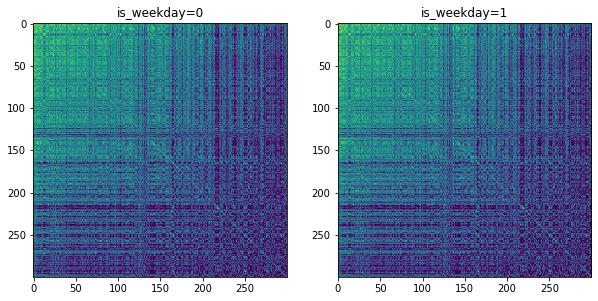

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,15))

for j in range(2):
    ax[j].set_title(f'is_weekday={j}')
    ax[j].imshow(np.log(weekday_adjs[is_weekday]/weekday_adjs[is_weekday].max()))
#     ax[j].imshow(np.exp(-(weekday_adjs[is_weekday]/1000)**2))

In [25]:
tc_mo_df = all_df[['start_id','end_id','month','trip_count']]. \
                groupby(by=['month','start_id','end_id',]).sum().reset_index(level=[2,1,0])

month_adjs = {}

for month in range(1,13):

    temp = tc_mo_df[tc_mo_df['month']==month]
    month_adjs[month] = make_matrix(temp,'start_id','end_id','trip_count',station_id_dict,fill=0)

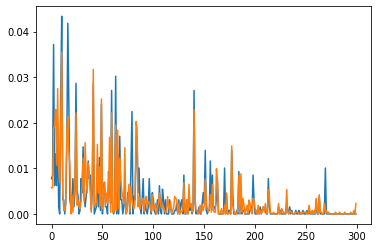

In [42]:
node = 140

for month in [1,8]:
    plt.plot(month_adjs[month][node]/month_adjs[month][node].sum())

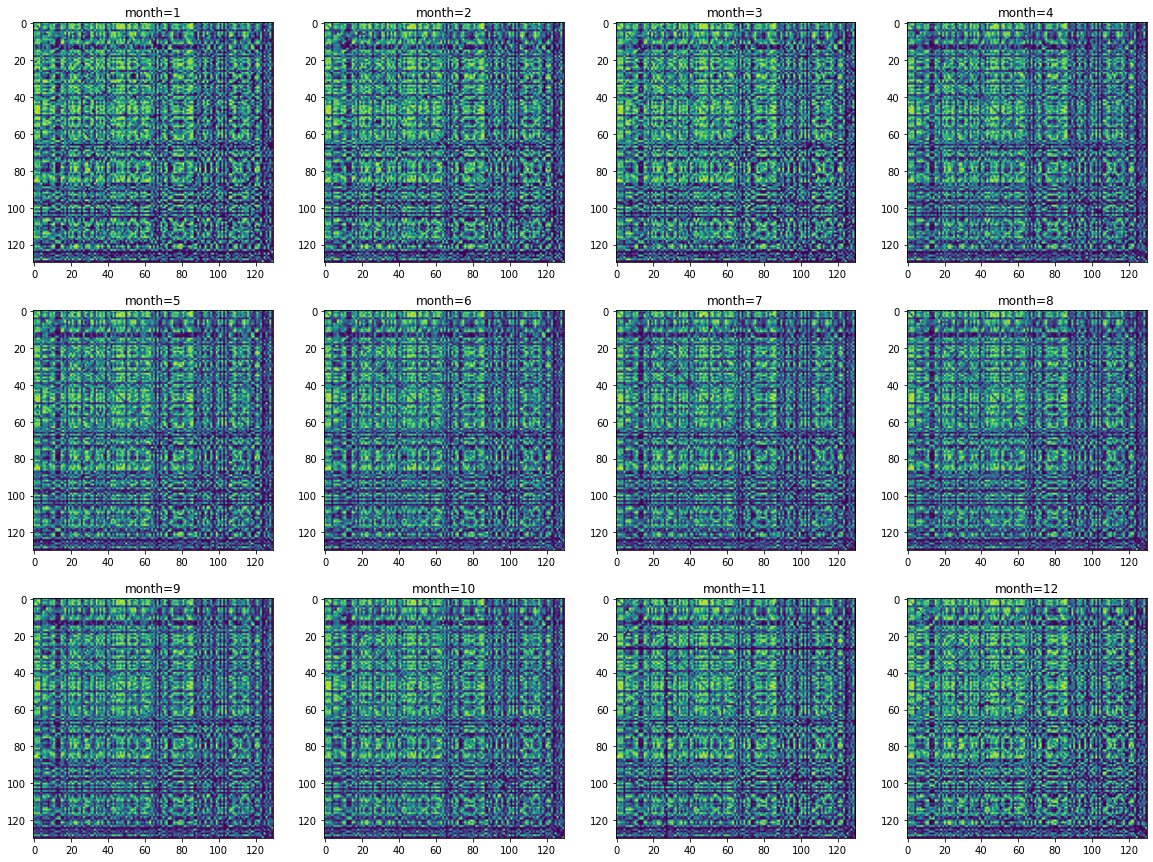

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20,15))

month = 1
for i in range(3):
    for j in range(4):
        ax[i,j].set_title(f'month={month}')
#         ax[i,j].imshow(np.log(month_adjs[month]/month_adjs[month].max()))
        ax[i,j].imshow(np.exp(-(month_adjs[month]/1000)**2))

        month += 1

In [10]:
tc_hr_df = all_df[['start_id','end_id','hour','trip_count']]. \
                groupby(by=['hour','start_id','end_id',]).sum().reset_index(level=[2,1,0])

hour_adjs = {}

for hour in range(0,24):

    temp = tc_hr_df[tc_hr_df['hour']==hour]
    hour_adjs[hour] = make_matrix(temp,'start_id','end_id','trip_count',station_id_dict,fill=0.)

In [11]:
for hour in range(0,24):
    np.save(f'./adjacency_matrices/trip_counts_{years[0]}{months[0]:02d}_{years[-1]}{months[-1]:02d}_top_{top_n_stations}_hour{hour}',hour_adjs[hour])

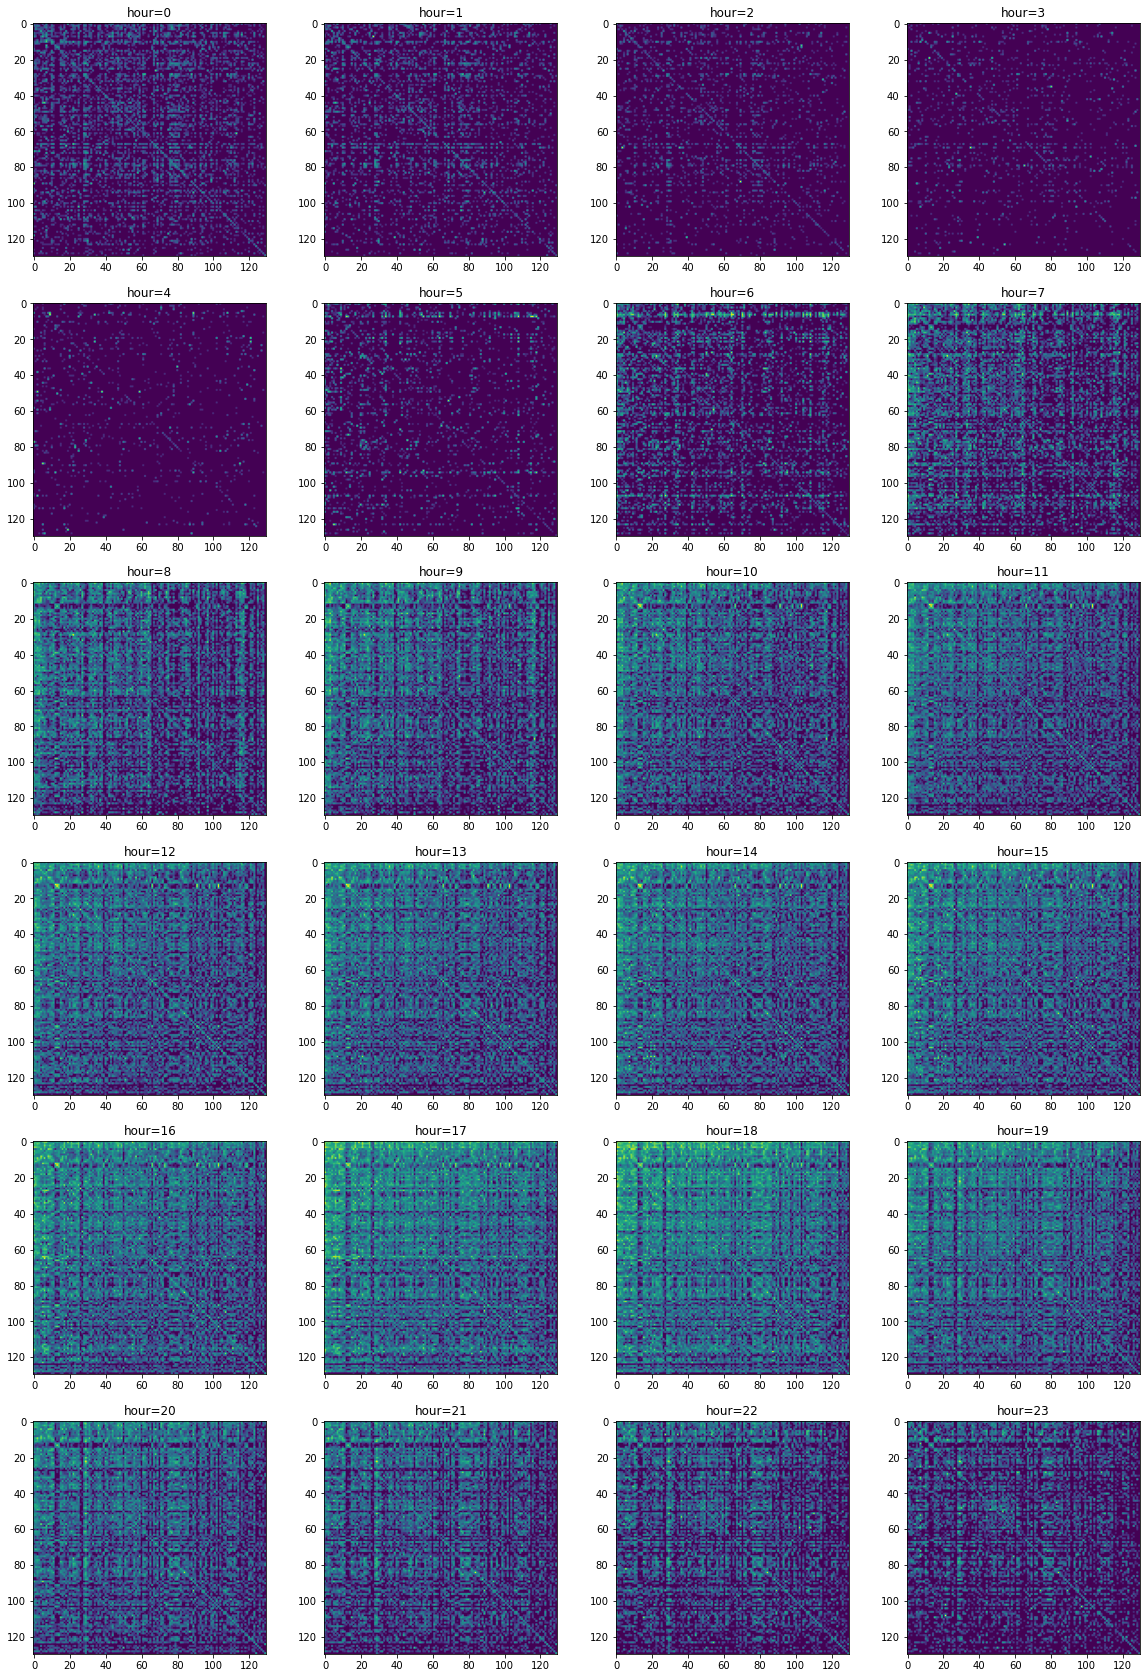

In [14]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(20,30))

hour = 0
for i in range(6):
    for j in range(4):
        ax[i,j].set_title(f'hour={hour}')
        ax[i,j].imshow(np.log(hour_adjs[hour]/hour_adjs[hour].max()))
        hour += 1

In [15]:
tc_dow_df = all_df[['start_id','end_id','dow','trip_count']]. \
                groupby(by=['dow','start_id','end_id',]).sum().reset_index(level=[2,1,0])

dow_adjs = {}

for dow in range(0,7):

    temp = tc_dow_df[tc_dow_df['dow']==dow]
    dow_adjs[dow] = make_matrix(temp,'start_id','end_id','trip_count',station_id_dict,fill=1.)

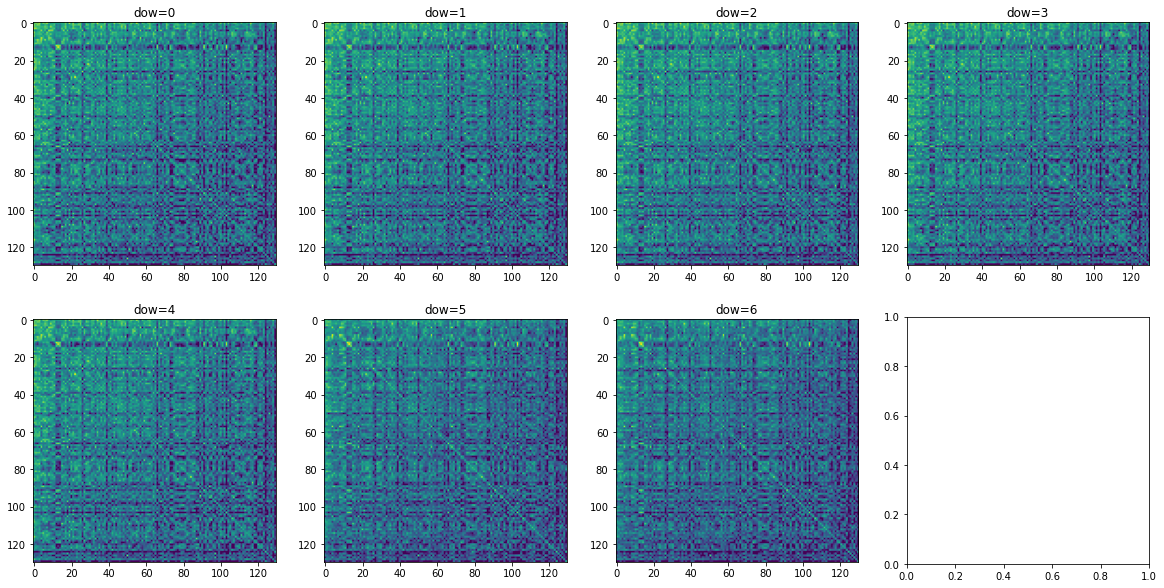

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

dow = 0
for i in range(2):
    for j in range(4):
        ax[i,j].set_title(f'dow={dow}')
        ax[i,j].imshow(np.log(dow_adjs[dow]/dow_adjs[dow].max()))
        dow += 1
        if dow==7:
            break